In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from utils.binance_loader import BinanceKlinesDownloader
from utils.visualizer_candles import CandleChartVisualizer

In [3]:
binance_loader = BinanceKlinesDownloader()
candle_visualizer = CandleChartVisualizer(use_volume_width=False)

In [4]:
data = binance_loader.download(start_date='2025-03-01', end_date='2025-04-09')

Чтение данных из кэша: binance_data_cache/BTCUSDT/BTCUSDT_1m_2025-03-01_to_2025-04-09.parquet.gz


In [5]:
sample_start_point = data.sample(n=1).index[0]

In [6]:
sample_start_point

np.int64(5569)

In [7]:
candle_visualizer.plot_candlestick(data.iloc[sample_start_point:sample_start_point+500])

## Feature generation

In [8]:
from utils.feature_generator import FeatureGenerator


feature_generator = FeatureGenerator()


In [9]:
features = feature_generator.transform(data)

In [10]:
features.head()[['ema_base', 'close']]

,ema_base,close
0,84433.294694,84422.48
1,84433.908533,84439.74
2,84430.282006,84395.83
3,84432.730386,84455.99
4,84429.617016,84400.04


## ENV test

In [11]:
feature_states = np.array(features.state_vector.tolist())
train_features = features.iloc[:int(len(feature_states) * 0.8)]
test_features = features.iloc[int(len(feature_states) * 0.8):].reset_index(drop=True)
train_feature_states = np.array(train_features.state_vector.tolist())
test_feature_states = np.array(test_features.state_vector.tolist())

In [12]:
feature_states.shape


(56611, 15)

In [13]:
from custom_envs.trading_env_v1 import TradingEnvV1
from utils.utils import transform_int_actions

Step: 999, Action: 2, PnL: -1.59


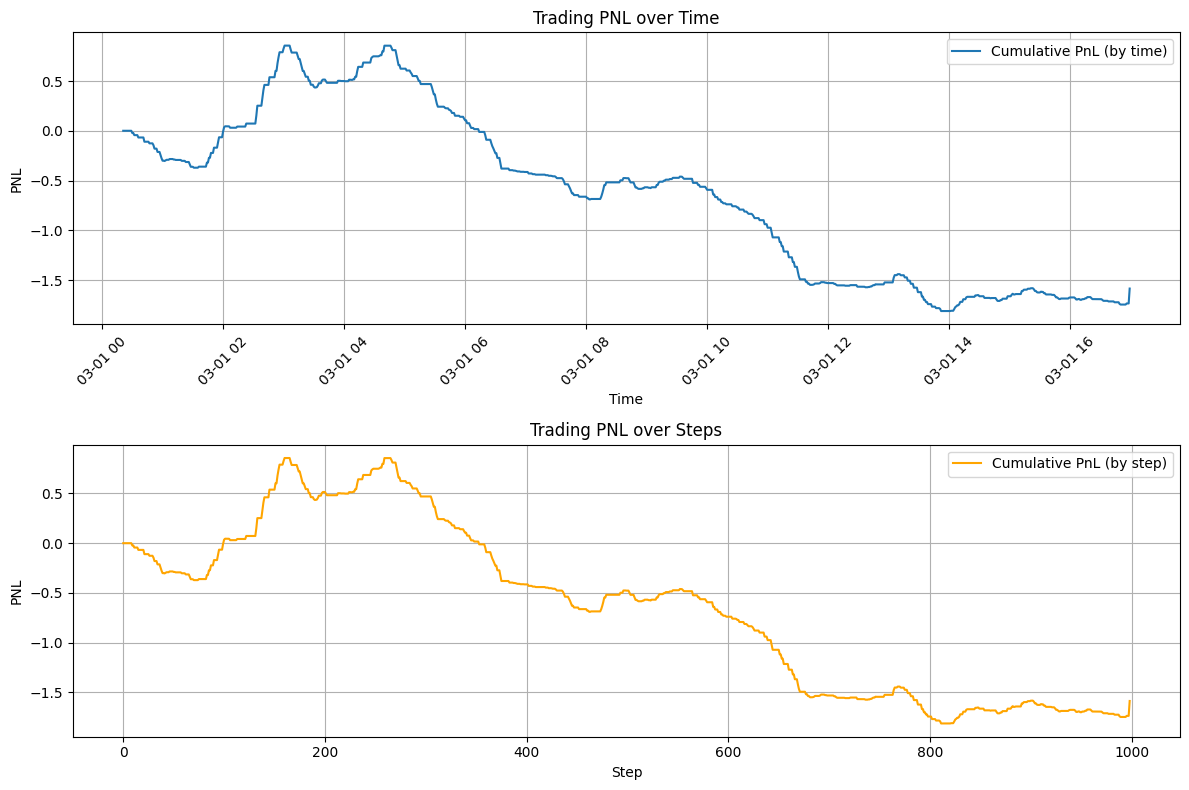

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

sample_start_point = data.sample(n=1).index[0]
sample_start_point = 0
N_TEST = 1000

# Предположим, что features уже загружены
env = TradingEnvV1(
    features=feature_states[sample_start_point:sample_start_point+N_TEST], 
    real_prices=features['close'].iloc[sample_start_point:sample_start_point+N_TEST].values, 
    initial_deposit=10000,
    commission=0.0005,
    # commission=0,
    reward_on_trades_only=True
)

obs, _ = env.reset()
done = False
rewards = []
rand_actions = []
timestamps = []
i = 0

while not done:
    i += 1
    possible_actions = env.get_possible_actions()
    action = np.random.choice(possible_actions)
    obs, reward, done, truncated, info = env.step(action)
    # if i == 5:
    #     print(obs)
    #     break
    
    rewards.append(env.pnl)
    rand_actions.append(action)
    
    # Сохраняем временную метку, соответствующую текущему шагу
    timestamps.append(features['timestamp'][env.current_step])

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Step: {i}, Action: {action}, PnL: {env.pnl:.2f}")
        
        fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharey=True)

        # График 1: PnL по времени
        axs[0].plot(timestamps, rewards, label='Cumulative PnL (by time)')
        axs[0].set_xlabel("Time")
        axs[0].set_ylabel("PNL")
        axs[0].set_title("Trading PNL over Time")
        axs[0].tick_params(axis='x', rotation=45)
        axs[0].grid(True)
        axs[0].legend()

        # График 2: PnL по шагам
        axs[1].plot(range(len(rewards)), rewards, label='Cumulative PnL (by step)', color='orange')
        axs[1].set_xlabel("Step")
        axs[1].set_ylabel("PNL")
        axs[1].set_title("Trading PNL over Steps")
        axs[1].grid(True)
        axs[1].legend()

        plt.tight_layout()
        plt.show()
        
clear_output(wait=True)
print(f"Step: {i}, Action: {action}, PnL: {env.pnl:.2f}")

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharey=True)

# График 1: PnL по времени
axs[0].plot(timestamps, rewards, label='Cumulative PnL (by time)')
axs[0].set_xlabel("Time")
axs[0].set_ylabel("PNL")
axs[0].set_title("Trading PNL over Time")
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)
axs[0].legend()

# График 2: PnL по шагам
axs[1].plot(range(len(rewards)), rewards, label='Cumulative PnL (by step)', color='orange')
axs[1].set_xlabel("Step")
axs[1].set_ylabel("PNL")
axs[1].set_title("Trading PNL over Steps")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

In [15]:
env.pnl

np.float64(-1.5853685040928311)

In [16]:
TOP_N = 99

candle_visualizer.plot_candlestick(features.iloc[sample_start_point:sample_start_point+TOP_N].reset_index(),
                                   actions=transform_int_actions(rand_actions)[:TOP_N])

In [34]:
from agents.dqn_agent import DQNAgent
from agents.double_dqn_agent import DoubleDQNAgent
from agents.random_agent import RandomAgent
from custom_envs.trading_env_v1 import TradingEnvV1
from custom_envs.trading_env_v1_torch import TradingEnvV1Torch

from utils.train_dqn_agent import train_dqn_agent

In [35]:

comission = 0.0005
epsilon_decay=0.99995
t_max = 2000
deposit = 10_000
epsilon_end = 0.2

In [36]:
env = TradingEnvV1Torch(features=train_feature_states, real_prices=train_features['close'], commission=comission,
                   initial_deposit=deposit, t_max=t_max, reward_on_trades_only=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [37]:
agent = DoubleDQNAgent(state_dim, action_dim, epsilon_decay=epsilon_decay, gamma=0.99, epsilon_end=epsilon_end)

In [38]:
agent.epsilon_end = 0.1 # for finuetuning purpose

In [41]:
rewards, pnl_per_episode, actions = train_dqn_agent(
    env, agent, num_episodes=200, 
    # t_max=t_max,
    target_update_freq=10
    )

 96%|█████████▌| 191/200 [1:13:36<03:44, 25.00s/it]

Episode 190, Total Reward: 10.81, Epsilon: 0.100, PNL: 0.88
Actions: {'buy': 0.4175, 'hold': 0.2965, 'sell': 0.286}


100%|██████████| 200/200 [1:17:18<00:00, 23.19s/it]


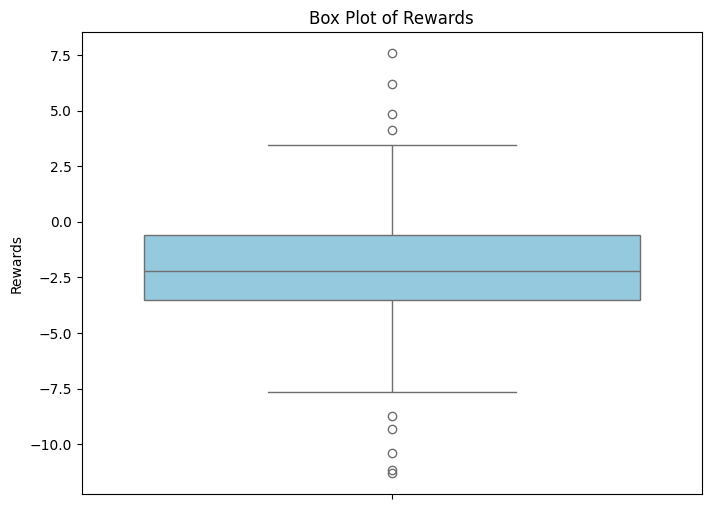

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Draw box plot for rewards
plt.figure(figsize=(8, 6))
sns.boxplot(data=pnl_per_episode, color='skyblue')
plt.title('Box Plot of Rewards')
plt.ylabel('Rewards')
plt.show()

# Check if we were in plus for rewards and PnL
all_rewards_positive = np.all(np.array(rewards) > 0)
all_pnl_positive = np.all(np.array(pnl_per_episode) > 0)


In [43]:
pd.Series(pnl_per_episode).describe()

count    200.000000
mean      -2.048652
std        2.710534
min      -11.303198
25%       -3.509766
50%       -2.229173
75%       -0.585256
max        7.584175
dtype: float64

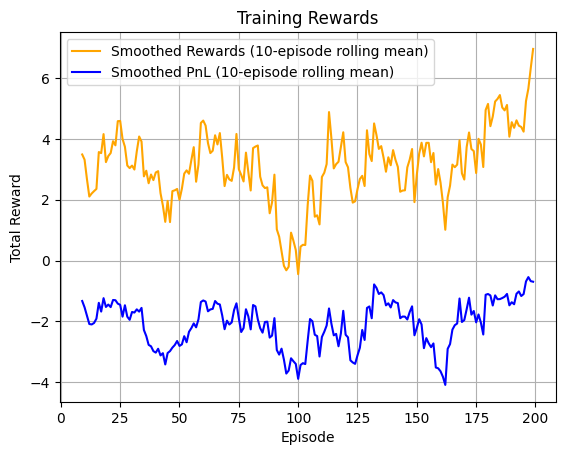

In [44]:
# plt.plot(pnl_per_episode, label='Total PnL')
rewards_smoothed = pd.Series(rewards).rolling(window=10).mean()
pnl_per_episode_smoothed = pd.Series(pnl_per_episode).rolling(window=10).mean()
plt.plot(rewards_smoothed, color='orange', label='Smoothed Rewards (10-episode rolling mean)')
plt.plot(pnl_per_episode_smoothed, label='Smoothed PnL (10-episode rolling mean)', color='blue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Rewards")
plt.grid(True)
plt.legend()

plt.show()

In [45]:
transform_int_actions(pd.DataFrame(actions).iloc[:,-1]).value_counts()

199
hold    805
buy     787
sell    408
Name: count, dtype: int64

In [46]:
test_env = TradingEnvV1(
    features=test_feature_states, real_prices=test_features['close'], 
    commission=comission, initial_deposit=1000,
    reward_on_trades_only=True,
    t_max=3000
)
# test_env = TradingEnvV1(
#     features=train_feature_states, real_prices=train_features['close'].values, 
#     commission=comission, initial_deposit=100,
#     reward_on_trades_only=True,
    
#     t_max=3000
# )

test_features.shape

(11323, 37)

In [47]:
from utils.validate_dqn_agent import validate_agent

In [48]:
total_pnl, end_pnls, rewards, actions = validate_agent(test_env, agent, test_features, render=True, episodes=1, verbose=False)

print(f"Total PnL on test set: {total_pnl:.2f}")

Validation Progress: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Average Reward over 1 episodes: 4.16
Total PnL on test set: 4.16


In [55]:
total_pnl, end_pnls, rewards, actions = validate_agent(test_env, agent, test_features, render=False, episodes=500, verbose=False)

print(f"Total PnL on test set: {total_pnl:.2f}")

Validation Progress: 100%|██████████| 500/500 [02:13<00:00,  3.75it/s]


Average Reward over 500 episodes: 3.39
Total PnL on test set: -3.52


In [50]:
actions_series = pd.Series(actions).replace({0: 'hold', 1: 'buy', 2: 'sell'})
actions_series.value_counts(normalize=True).sort_index()

buy     0.427
hold    0.464
sell    0.109
Name: proportion, dtype: float64

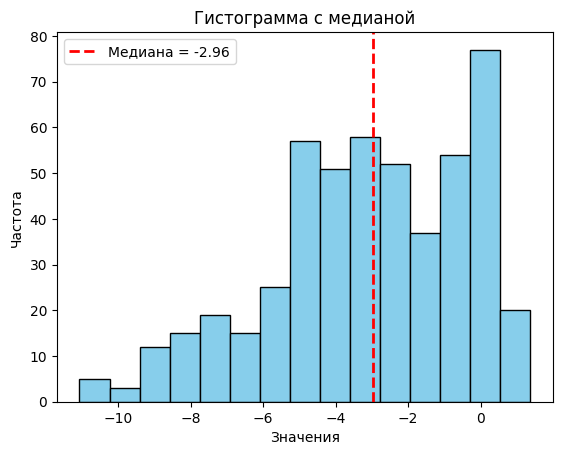

In [51]:
# plt.hist(end_pnls)
plt.hist(end_pnls, bins=15, color='skyblue', edgecolor='black')

# Вычисляем медиану
median_value = np.median(end_pnls)

# Рисуем вертикальную линию на медиане
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f'Медиана = {median_value:.2f}')

# Добавим легенду и заголовок
plt.legend()
plt.title('Гистограмма с медианой')
plt.xlabel('Значения')
plt.ylabel('Частота')

plt.show()

In [52]:
random_agent = RandomAgent(env.action_space.n)

In [53]:
total_pnl, end_pnls, rewards, actions = validate_agent(test_env, random_agent, test_features,
                                                       render=False, verbose=False, episodes=500)

print(f"Total PnL on test set: {total_pnl:.2f}")

Validation Progress: 100%|██████████| 500/500 [00:40<00:00, 12.27it/s]


Average Reward over 500 episodes: 2.33
Total PnL on test set: 3.07


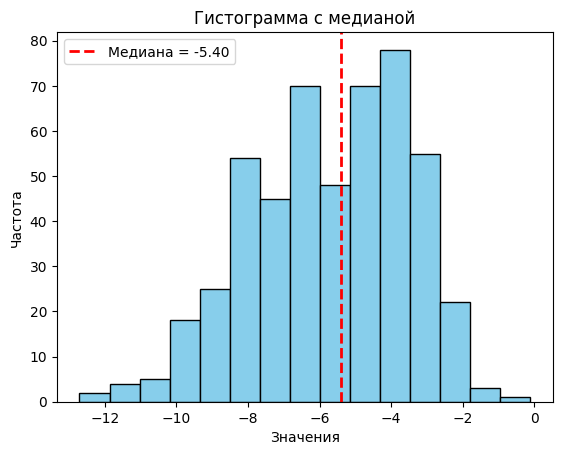

In [54]:
# plt.hist(end_pnls)
plt.hist(end_pnls, bins=15, color='skyblue', edgecolor='black')

# Вычисляем медиану
median_value = np.median(end_pnls)

# Рисуем вертикальную линию на медиане
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f'Медиана = {median_value:.2f}')

# Добавим легенду и заголовок
plt.legend()
plt.title('Гистограмма с медианой')
plt.xlabel('Значения')
plt.ylabel('Частота')

plt.show()

## Frame stack

In [107]:
from custom_envs.trading_env_frame_stack import FrameStackTradingEnvV1
from custom_envs.trading_env_v1 import TradingEnvV1
from utils.validate_dqn_agent import validate_agent
from agents.dqn_agent_for_frames import DQNCNNAgent
from agents.double_dqn_agent_for_frames import DoubleDQNCNNAgent

In [108]:
n_stacks = 6

In [109]:
base_trading_env = TradingEnvV1Torch(
    features=train_feature_states, real_prices=train_features['close'].values,
    commission=comission, initial_deposit=deposit,
    t_max=t_max,
    warmup_steps=n_stacks,
    reward_on_trades_only=True
    )
base_env_state_dim = env.observation_space.shape[0]
base_env_action_dim = env.action_space.n

In [110]:
frame_stack_env = FrameStackTradingEnvV1(base_env=base_trading_env, stack_size=n_stacks, return_pt=True)
state_dim = frame_stack_env.observation_space.shape[0]
action_dim = frame_stack_env.action_space.n

In [111]:
epsilon_end = 0.15 # for finuetuning purpose

In [112]:
frame_dqn_agent = DQNAgent(state_dim, action_dim, epsilon_decay=epsilon_decay, gamma=0.99, epsilon_end=epsilon_end)
frame_cnn_dqn_agent = DQNCNNAgent(base_env_state_dim, action_dim, num_frames=n_stacks, epsilon_decay=epsilon_decay, gamma=0.99, epsilon_end=epsilon_end)
frame_cnn_double_dqn_agent = DoubleDQNCNNAgent(base_env_state_dim, action_dim, num_frames=n_stacks, epsilon_decay=epsilon_decay, gamma=0.99, epsilon_end=epsilon_end)

In [ ]:
rewards, pnl_per_episode, actions = train_dqn_agent(
    frame_stack_env,  frame_cnn_double_dqn_agent, base_env=base_trading_env,
    num_episodes=100, 
    # t_max=t_max,
    target_update_freq=10
    )

 11%|█         | 11/100 [31:25<4:52:46, 197.37s/it]

Episode 10, Total Reward: -0.79, Epsilon: 0.272, PNL: -3.30
Actions: {'hold': 0.35932033983008493, 'buy': 0.3403298350824588, 'sell': 0.3003498250874563}


 14%|█▍        | 14/100 [39:23<4:07:33, 172.71s/it]

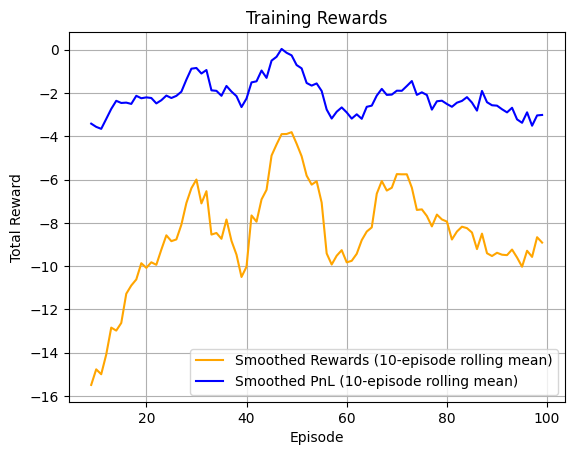

In [ ]:
# plt.plot(pnl_per_episode, label='Total PnL')
rewards_smoothed = pd.Series(rewards).rolling(window=10).mean()
pnl_per_episode_smoothed = pd.Series(pnl_per_episode).rolling(window=10).mean()
plt.plot(rewards_smoothed, color='orange', label='Smoothed Rewards (10-episode rolling mean)')
plt.plot(pnl_per_episode_smoothed, label='Smoothed PnL (10-episode rolling mean)', color='blue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Rewards")
plt.grid(True)
plt.legend()

plt.show()

In [ ]:
test_stack_env = FrameStackTradingEnvV1(test_env, stack_size=n_stacks)


In [ ]:
total_reward_val, end_pnls_val, rewards_val, actions_val = validate_agent(test_stack_env, frame_dqn_agent, test_features,
                                                       render=True, verbose=False, episodes=1, base_env=test_env)

print(f"Total PnL on test set: {total_pnl:.2f}")

Validation Progress: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Average Reward over 1 episodes: 0.00
Total PnL on test set: -2.46


In [ ]:
transform_int_actions(actions_val).value_counts()

hold    2992
sell       3
Name: count, dtype: int64

In [ ]:
total_reward_val, end_pnls_val, rewards_val, actions_val = validate_agent(test_stack_env, frame_dqn_agent, test_features,
                                                       render=False, verbose=False, episodes=500, base_env=test_env)

print(f"Total PnL on test set: {total_pnl:.2f}")

Validation Progress: 100%|██████████| 500/500 [02:33<00:00,  3.25it/s]


Average Reward over 500 episodes: 0.00
Total PnL on test set: -2.46


In [ ]:
transform_int_actions(actions_val).value_counts()

hold    2993
sell       2
Name: count, dtype: int64

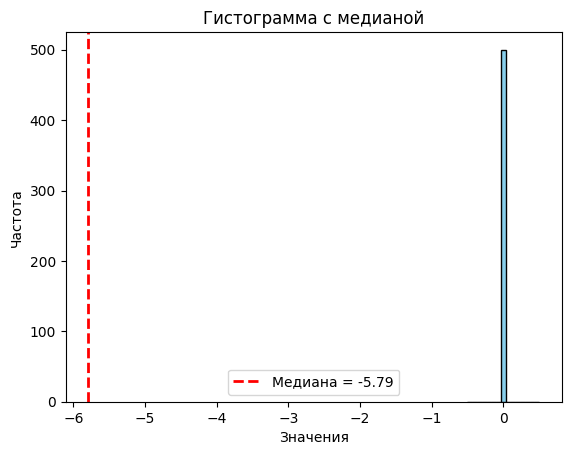

In [ ]:
# plt.hist(end_pnls)
plt.hist(end_pnls_val, bins=15, color='skyblue', edgecolor='black')

# Вычисляем медиану
median_value = np.median(end_pnls)

# Рисуем вертикальную линию на медиане
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f'Медиана = {median_value:.2f}')

# Добавим легенду и заголовок
plt.legend()
plt.title('Гистограмма с медианой')
plt.xlabel('Значения')
plt.ylabel('Частота')

plt.show()